# **Most Dangerous Road Accidents**

In [1]:
pip install xgboost catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from joblib import load
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## **1. Introduction**

In our current day and age, traveling has become an essential part of of our lives. With the improvement of the infrastructure and technology, moving from one place to another is becoming increasingly faster and cheaper. Sadly, although roads have become much safer as well, they still hold big risks. 

In this project, we are going to explore the biggest factors, which play a role in the severity of the accidents on the road. To do this, we will try to find patterns in the data we currently have, using machine learning models. By the end of this analysis, we aim to have a clearer understanding of what exactly are the most dangerous factors on the road.

## **2. Previous Research**


The UK government has conducted extensive research on road safety, focusing on various factors influencing accident severity and frequency. Key areas of study include:

#### 1. **Driver Behavior**
- Investigations into the impact of mobile phone usage, speeding, and impaired driving on accident rates.

#### 2. **Vehicle Safety**
- Evaluations of vehicle design and technology advancements aimed at reducing casualties.

#### 3. **Road Infrastructure**
- Analysis of how road design, signage, and maintenance affect accident occurrences.

#### 4. **Statistical Reporting**
- Annual publications like *"Reported Road Casualties Great Britain"* provide comprehensive data on accidents, including causes and outcomes.


These efforts aim to inform policy decisions and implement measures to enhance road safety across the UK.

## **3. Data Used**
The data we are going to use consists of three datasets from the [Website of the UK government](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). Here we can find data on road accidents, which occured in the last 5 years. There are over 600k observations. All of the features are encoded with numbers. [Here is the guide on their meaning](https://doc.ukdataservice.ac.uk/doc/7752/mrdoc/pdf/7752_ukds_user_guide_2014.pdf). The primary variable we are going to use is called "accident_severity", which can be interpreted as follows:
- **1 (Fatal)**: Accidents resulting in at least one fatality.
- **2 (Serious)**: Significant injuries requiring hospitalization.
- **3 (Slight)**: Minor injuries or no injuries.


## **4. Project structure**
#### **1. Preparing the Datasets**
-    Merging the three datasets
-    Dropping unusable features
-    Handling missing values
#### **2. Exploratory Data Analysis**
-    Exploration of the targer variable
-    Numerical value analysis
-    Categorical feature analysis
#### **3. Preprocessing, Model building and evaluation**
-    Logistic Regression
-    Decision Tree
-    Random Forest
-    XGBoost
-    CatBoost 

## **Preparing the Datasets**
The dataset has been prepared in a separate notebook, called "dataset_preparation.ipynb", located in the "notebooks" folder.

We are going to load it now:

In [3]:
data = pd.read_csv("data/data_prepared.csv", index_col = 0).replace({
    "accident_severity" : {1 : "Fatal",
                           2 : "Serious",
                           3 : "Slight"}})

## **Exploratory Data Analysis**
First, we are going to examine the distribution of our target feature "accident_severity". To do that, we are going to draw a countplot:

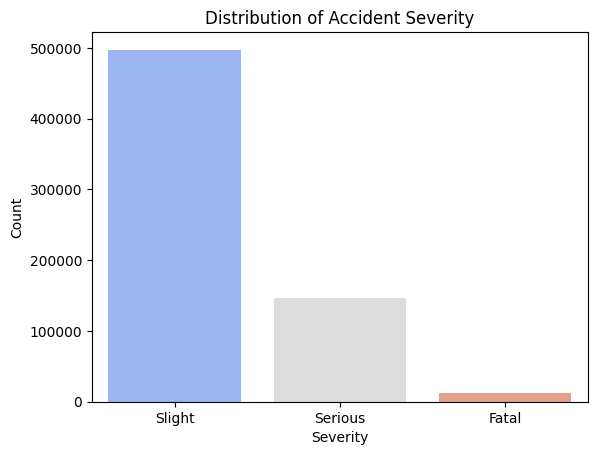

In [4]:
sns.countplot(x="accident_severity", hue = "accident_severity", legend = False, data=data, palette="coolwarm")
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

Unsurprisingly, most accidents are classified as "slight". This huge imbalance would be a potential problem further on, when we train our models.

<!-- Now let's convert all categorical features to str: -->

In [5]:
categorical_features = ["day_of_week", "first_road_class", "road_type", "junction_detail", 
                    "second_road_class", "pedestrian_crossing_human_control", 
                   "pedestrian_crossing_physical_facilities", "light_conditions", "weather_conditions",
                   "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards",
                   "did_police_officer_attend_scene_of_accident", "vehicle_type", "towing_and_articulation",
                   "vehicle_manoeuvre", "vehicle_location_restricted_lane", "junction_location",
                   "skidding_and_overturning", "hit_object_in_carriageway", "hit_object_off_carriageway",
                   "vehicle_leaving_carriageway", "first_point_of_impact", "sex_of_driver", "vehicle_left_hand_drive",
                   "journey_purpose_of_driver", "casualty_class", "sex_of_casualty", 
                   "pedestrian_location", "pedestrian_movement", "car_passenger", "bus_or_coach_passenger",
                   "pedestrian_road_maintenance_worker", "vehicle_direction_from", "vehicle_direction_to",
                   "age_band_of_casualty", "day_of_month", "month", "time_rounded",
                   "accident_severity", "escooter_flag"]

In [6]:
for col in categorical_features:
    data[col] = data[col].astype(str)

We are going to create a dataset with the proportions for each value for each feature of the dataset. It will be heavily used for plotting.

In [7]:
categorical_features.remove("accident_severity")

In [8]:
proportional_datasets = []

for feature in categorical_features:
    severity_distribution = data.groupby([feature, "accident_severity"]).size().reset_index(name="count")
    severity_distribution["proportion"] = severity_distribution.groupby(feature)["count"].transform(lambda x: x / x.sum())
    severity_distribution["feature"] = feature
    
    severity_distribution = severity_distribution.rename(columns={feature: "category"})
    
    proportional_datasets.append(severity_distribution)

combined_dataset = pd.concat(proportional_datasets, ignore_index=True)


In [9]:
categorical_features.append("accident_severity")

Then we are going to define a function to draw plots for the proportional distributions for each value of a given feature.

In [10]:
def print_stacked_plot(selected_feature, feature_dict=None):
    feature_data = combined_dataset[combined_dataset["feature"] == selected_feature]

    stacked_data = feature_data.pivot(index="category", columns="accident_severity", values="proportion").fillna(0)

    original_counts = feature_data.groupby("category")["count"].sum()
    stacked_data["weight"] = stacked_data.index.map(original_counts)

    stacked_data.rename(columns={"1": "Slight", "2": "Serious", "3": "Fatal"}, inplace=True)

    if feature_dict is not None:
        stacked_data["mapped_category"] = stacked_data.index.map(feature_dict)

        grouped = stacked_data.groupby("mapped_category")
        weighted_proportions = grouped.apply(
            lambda group: (group.iloc[:, :-2].multiply(group["weight"], axis=0).sum()) / group["weight"].sum()
        )

        stacked_data = weighted_proportions

    stacked_data = stacked_data.sort_values(by="Fatal")
    
    stacked_data.plot(
        kind="barh",
        stacked=True,
        figsize=(12, 6),
        colormap="coolwarm",
    )
    
    plt.title(f"Proportional Accident Severity by {selected_feature}", fontsize=16)
    plt.ylabel(selected_feature, fontsize=12)
    plt.xlabel("Proportion of Accidents", fontsize=12)
    plt.legend(title="Accident Severity", loc="upper right")
    plt.xticks(rotation=45)
    plt.show()


Now let's explore the categorical features. For example, let's look into the relationship between weather conditions and accident severity:

In [11]:
weather_conditions_mapping = {
    "1" : "Fine, no high winds",
    "2" : "Raining, no high winds",
    "3" : "Snowing, no high winds",
    "4" : "Fine + high winds",
    "5" : "Raining + high winds",
    "6" : "Snowing + high winds",
    "7" : "Fog or mist",
    "8" : "Other",
    "-1": "Unknown"
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


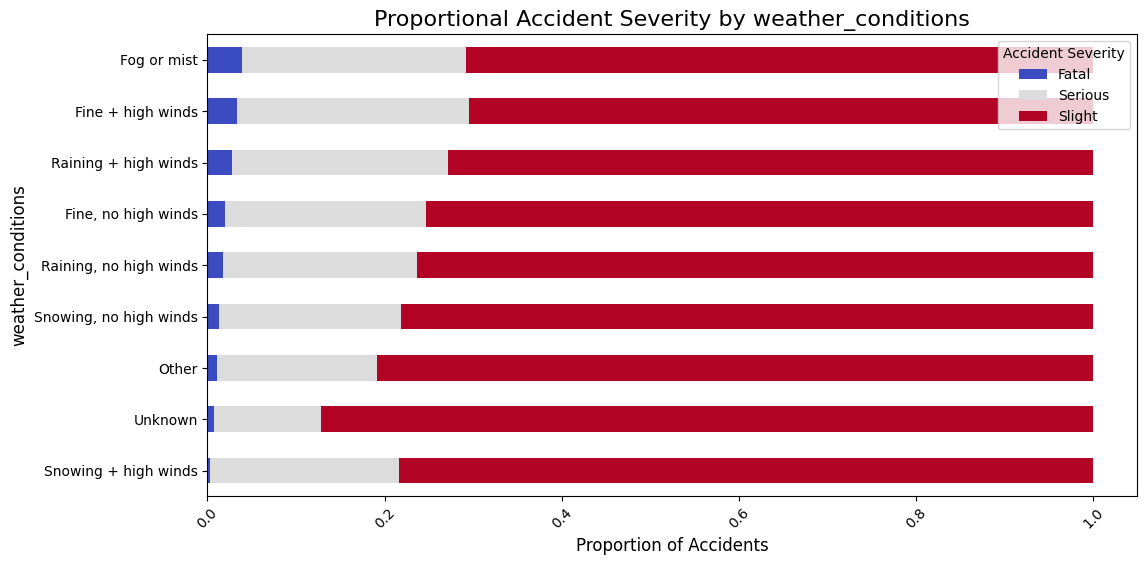

In [12]:
print_stacked_plot("weather_conditions", weather_conditions_mapping)

The highest rate of severe accidents is observed when there is fog or mist. It makes sense, that when the vision is bad, the drivers have less time to react, and therefore end up in a worse collision. More surprising is the observation, that when it's snowing, the accidents are less severe. That may be due to the lower speed when driving in the snow.

Now let's draw a plot for the speed limit and the severity, as well as total count:

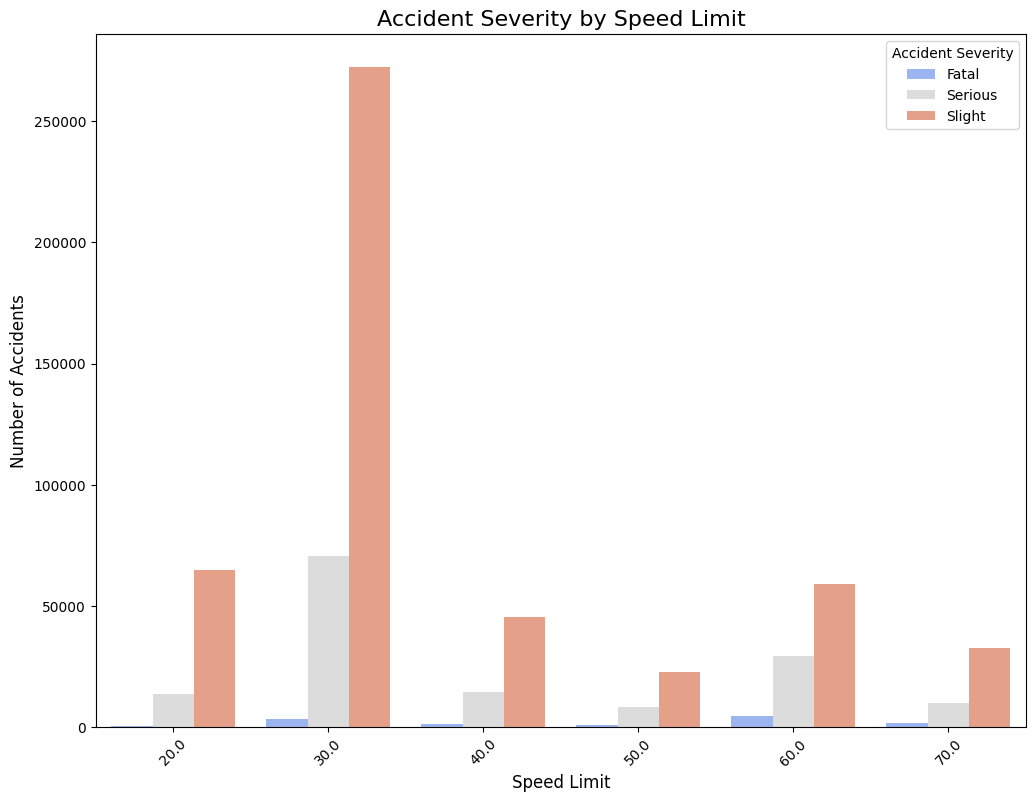

In [13]:
plt.figure(figsize=(12, 9))
sns.countplot(
    data=data, 
    x="speed_limit", 
    hue="accident_severity", 
    palette="coolwarm",
    hue_order=["Fatal", "Serious", "Slight"]
)
plt.title("Accident Severity by Speed Limit", fontsize=16)
plt.xlabel("Speed Limit", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Accident Severity", loc="upper right")
plt.show()

As we can see, in total the most accidents happen with a speed limit of 30mph, which is the speed limit in the bigger part of the populated areas. It's not surprising, because most of the driving happens there.

Now let's take a look into the lighting conditions:

In [14]:
light_conditions_mapping = {
    "1.0" : "Daylight",
    "4.0" : "Darkness - lights lit",
    "5.0" : "Darkness - lights unlit",
    "6.0" : "Darkness - no lighting",
    "7.0" : "Darkness - lighting unknown",
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


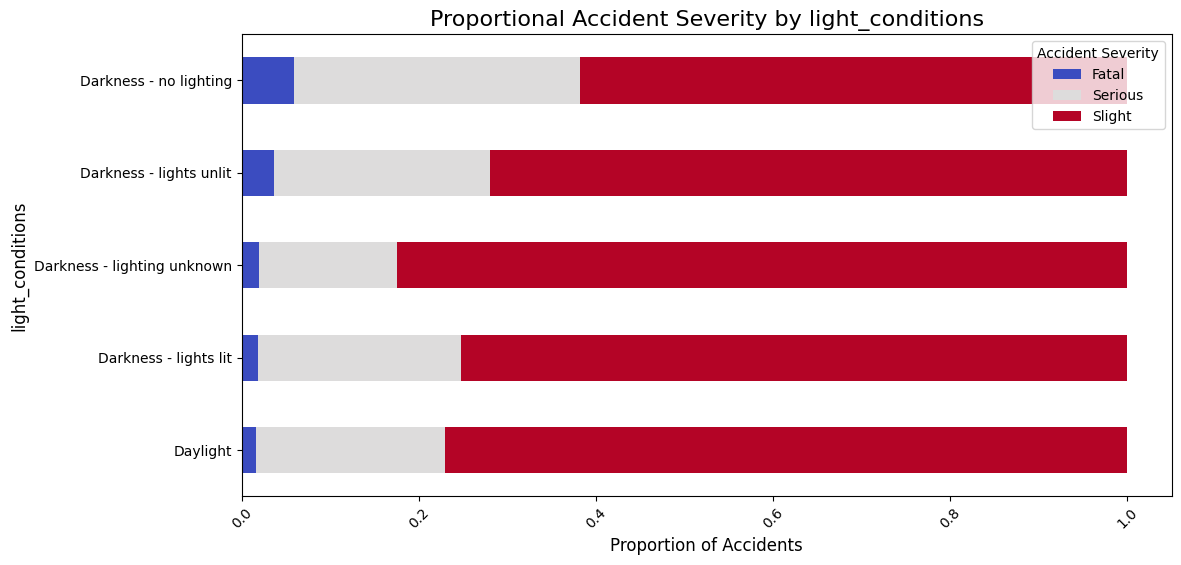

In [15]:
print_stacked_plot("light_conditions", light_conditions_mapping)

Here we see a clear pattern emerge. The worse the lighting, the worse the accident. Now let's see what the models tell us about the features:

## **Preprocessing and Model Building**
For this step, we are going to create various models and fine-ture their parameters so that we can find the one, that best predicts the severity of the accident. In this notebook, we are going to use pre-trained models and the code for every one of them will be included in separate notebooks. Some of them have been trained on Google Colab.

#### **1. Logistic regression**
Starting with one of the most basic models, we have to perform some transformations on the data first.

First, we are going to load the already prepared train and test datasets for the logistic regression. The whole preparation of the data has been done in the "Logistic_regression_tests.ipynb" notebook:

In [16]:
X_train_for_logreg = load("data/X_train_for_logistic_regression.joblib")
y_train_for_logreg = load("data/y_train_for_logistic_regression.joblib")

X_test_for_logreg = load("data/X_test_for_logistic_regression.joblib")
y_test_for_logreg = load("data/y_test_for_logistic_regression.joblib")

Now let's load the logistic regression:

In [17]:
logistic_regression = load("models/best_logistic_regression_model.joblib")

Now let's take a look again at the score for the testing dataset:

In [18]:
logistic_regression.score(X_test_for_logreg, y_test_for_logreg)

0.4910397144132084

And the classification report and the confusion matrix:

In [19]:
y_pred = logistic_regression.predict(X_test_for_logreg)

In [20]:
print(classification_report(y_test_for_logreg, y_pred))

              precision    recall  f1-score   support

           1       0.04      0.69      0.08      2367
           2       0.25      0.10      0.14     25007
           3       0.80      0.60      0.69     84676

    accuracy                           0.49    112050
   macro avg       0.37      0.46      0.30    112050
weighted avg       0.66      0.49      0.55    112050



In [21]:
cm = confusion_matrix(y_test_for_logreg, y_pred)

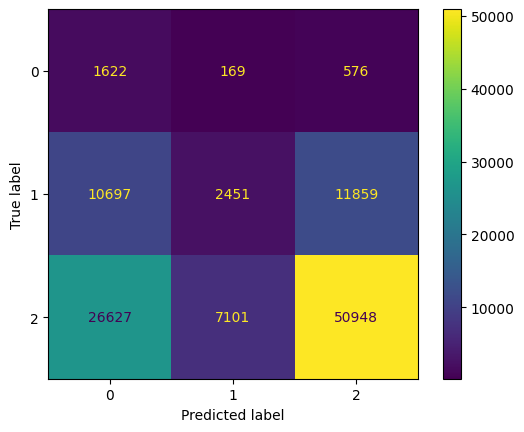

In [22]:
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

As we can see, the results don't look promising at all. There is no reason to even analyze the feature importances for this model. It just performs too poorly. Now let's free the datasets we just loaded from the memory:

In [23]:
del X_train_for_logreg
del y_train_for_logreg

del X_test_for_logreg
del y_test_for_logreg

gc.collect()

4044

#### **2. Decision tree**

The next model we're going to try is the decision tree. The tuning and training are performed in "decision_tree_testing.ipynb". This time, it has been trained in Google Colab. Now let's load the training and testing set, this time we're going to give them a more generic name, because they will be used until the end of the notebook.

In [24]:
X_train = pd.read_csv("data/X_train.csv", index_col = 0)
y_train = pd.read_csv("data/y_train.csv", index_col = 0)

X_test = pd.read_csv("data/X_test.csv", index_col = 0)
y_test = pd.read_csv("data/y_test.csv", index_col = 0)

Now loading the model:

In [25]:
decision_tree = load("models/best_decision_tree_model.joblib")

/home/gecata/.local/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Let's look at its accuracy:

In [26]:
decision_tree.score(X_train, y_train)

0.999995537706381

In [27]:
decision_tree.score(X_test, y_test)

0.7434270414993307

That looks way more promising, although it overfitted. Let's take a look at its other metrics:

In [28]:
y_pred = decision_tree.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.41      0.40      2367
           2       0.46      0.48      0.47     25007
           3       0.84      0.83      0.84     84676

    accuracy                           0.74    112050
   macro avg       0.56      0.57      0.57    112050
weighted avg       0.75      0.74      0.75    112050



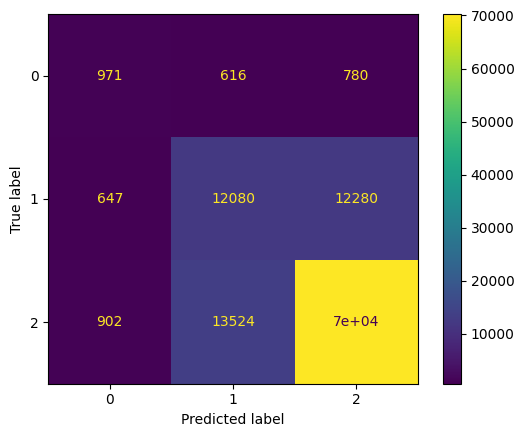

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

These results seem acceptable. Now we are going to take a look at what it thinks the most important features are:

In [31]:
def plot_feature_importances(model):
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False, figsize=(20, 6))
    plt.title("Feature Importances")
    plt.show()

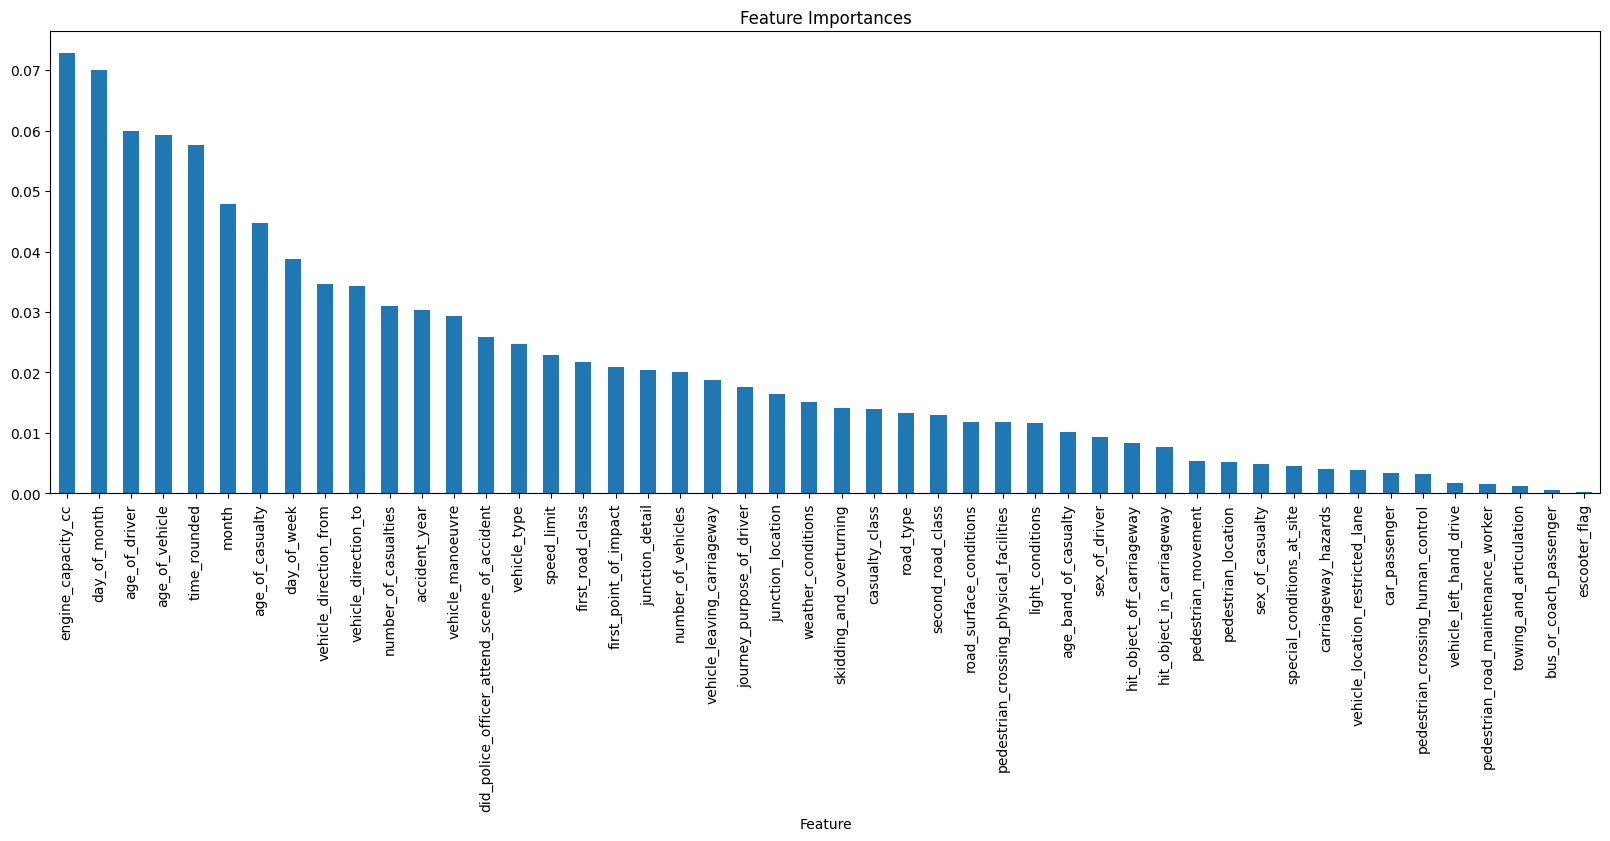

In [32]:
plot_feature_importances(decision_tree)

The most important metric seems to be the engine capacity. That's unexpected. Let's take a look at this with a violin plot:

In [33]:
def plot_violin_plot(feature, logscaling = False):
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=data,
        hue="accident_severity",
        y=feature,
        palette="coolwarm",
        density_norm="count",
    )
    plt.title(f"{feature} Distribution by Accident Severity", fontsize=16)
    plt.xlabel("Accident Severity", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    if logscaling:
        plt.yscale("log")
    plt.show()

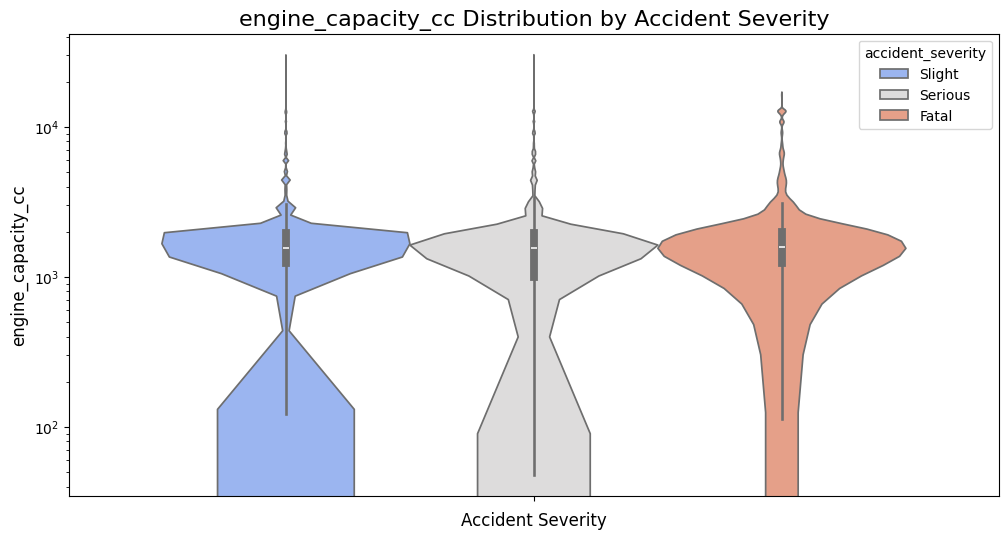

In [34]:
plot_violin_plot("engine_capacity_cc", logscaling = True)

It looks sublte, but it looks like the higher the engine capacity, the more likely it is for an accident to become severe. Maybe drivers with bigger engines are more likely to drive dangerously. Let's create the same plot for the age of the driver, a metric, which is also high in the importance order:

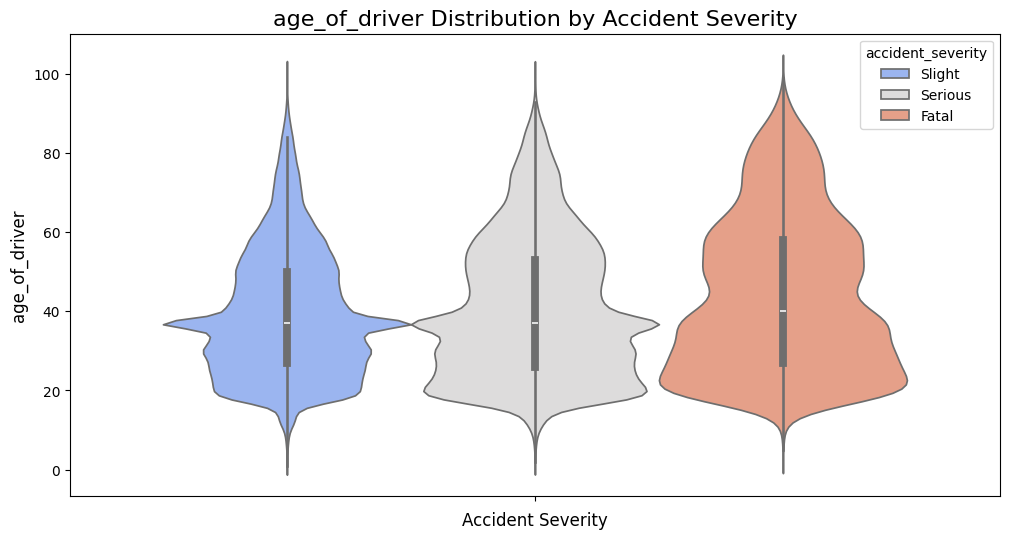

In [35]:
plot_violin_plot("age_of_driver")

No surprises here, younger drivers tend to be involved in more severe accidents.

#### **3. Random Forest**
After taking a look at the decision tree, it makes sense to explore an ensemble of trees next. The next model we're going to take a look at is RandomForest. Again, everything is done in Colab and is saved in a file, called "randomforest_tests.ipynb". Let's load the model:

In [36]:
random_forest = load("models/best_random_forest_model.joblib")

/home/gecata/.local/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gecata/.local/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Now let's take a look at the scores:

In [37]:
random_forest.score(X_train, y_train)

0.9874319500223114

In [38]:
random_forest.score(X_test, y_test)

0.8162516733601071

Here the results have become even better, as expected. Now let's take a look at the other metrics just like with the decision tree:

In [39]:
y_pred = random_forest.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.41      0.55      2367
           2       0.65      0.47      0.54     25007
           3       0.85      0.93      0.89     84676

    accuracy                           0.82    112050
   macro avg       0.77      0.60      0.66    112050
weighted avg       0.80      0.82      0.80    112050



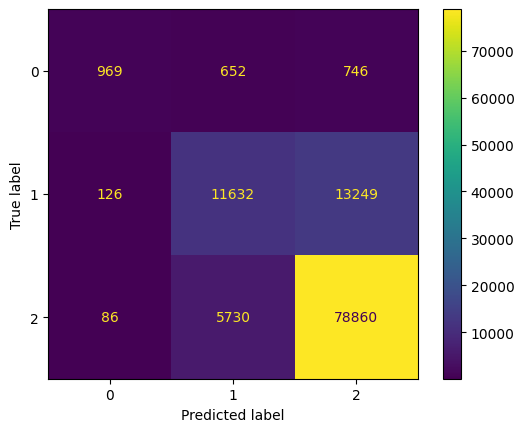

In [41]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

These results look even better! Now let's again look at the feature importances:

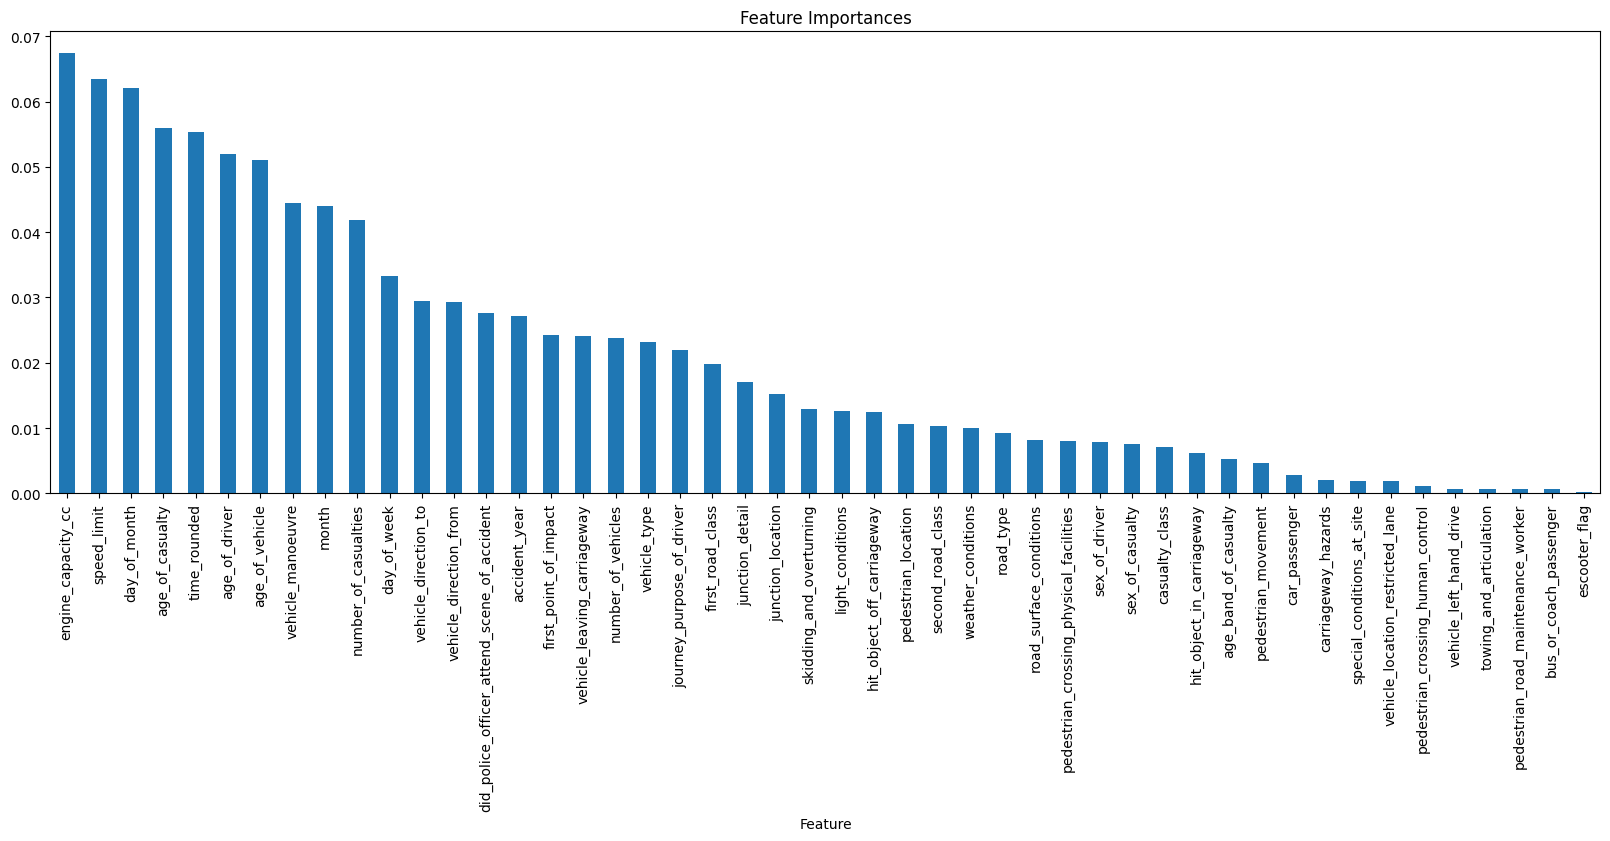

In [42]:
plot_feature_importances(random_forest)

Here, a new feature becomes very important - the speed limit. Let's look into it:

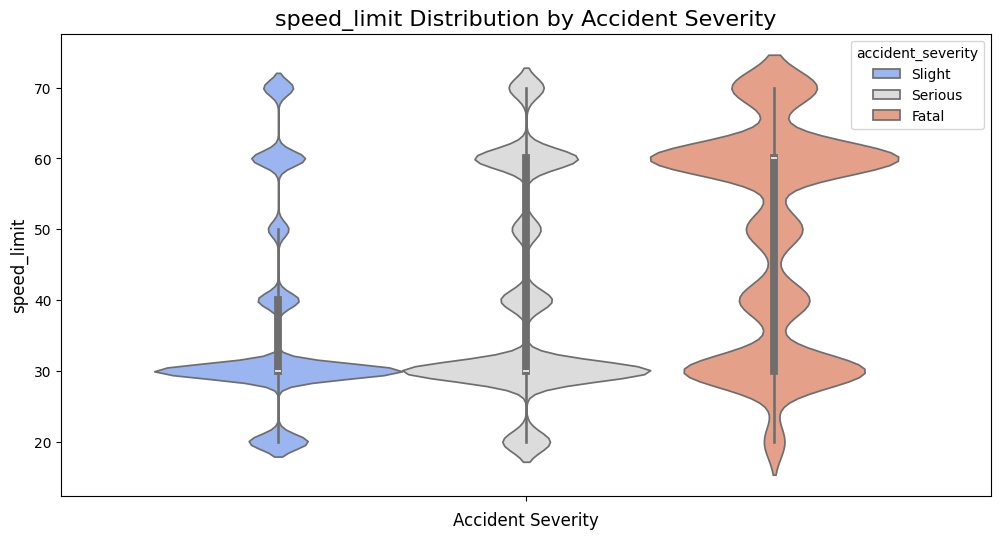

In [43]:
plot_violin_plot("speed_limit")

Here it becomes very apparent: Roads with a speed limit of 60mph are the most dangerous. These are the roads, where the infrastructure is not like a motorway so it has sharper corners and way less visibility. At the same time drivers are driving way more quickly than in towns for example. Another interesting metric to take a look at is the age of the casualty:

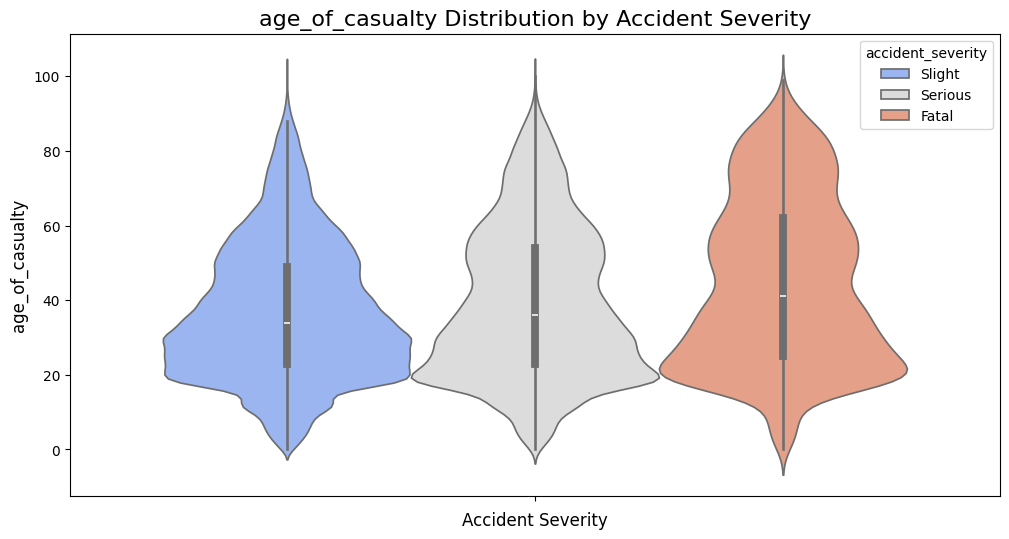

In [44]:
plot_violin_plot("age_of_casualty")

Here, the difference is not that apparent, but it looks like older people tend to be more involved in fatal accidents. That is most likely because their bodies have become more fragile, due to their age.

#### **4. XGBoost**
The next model we are going to look at is called XGBoost. Sadly, it does not perform the same on this notebook so the evaluation is also done in "xgboost_testing.ipynb". 

Here is an overview of the metrics:
- train dataset accuracy: 0.9081302989736725
- test dataset accuracy: 0.7713520749665328
- weighed f1-score: 0.7755920282500351

Surprisingly, it performed worse than RandomForest. Surprising here is, that according to this model, "did_police_officer_attend_scene_of_accident" is of very high importance. Let's look into it:

In [45]:
police_officer_mapping = {
    "1.0" : "Yes",
    "2.0" : "No",
    "3.0" : "No - accident was reported \n using a self completion form",
    "nan" :  "Yes",
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


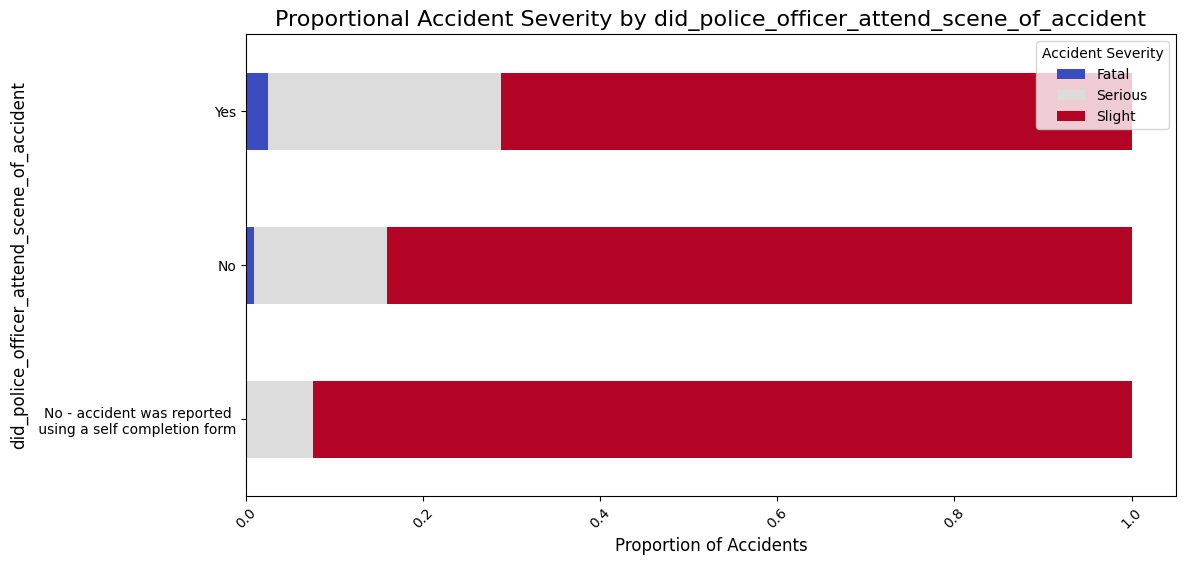

In [46]:
print_stacked_plot("did_police_officer_attend_scene_of_accident", police_officer_mapping)

It makes sense, that if the accident is reported via a self completion form, there wouldn't be a fatal outcome.

Another interesting feature, that came up is the vehicle type. Let's look:

In [47]:
vehicle_type_mapping = {
    "1"  : "Pedal cycle",
    "2"  : "Motorcycle",
    "3"  : "Motorcycle",
    "4"  : "Motorcycle",
    "5"  : "Motorcycle",
    "8"  : "Taxi / Private hire car",
    "9"  : "Car",
    "10" : "Minibus",
    "11" : "Bus or coach",
    "16" : "Ridden horse",
    "17" : "Agricultural vehicle",
    "18" : "Tram",
    "19" : "Van / Goods 3.5 tonnes mgw or under",
    "20" : "Goods over 3.5t",
    "21" : "Goods over 3.5t",
    "22" : "Scooter",
    "23" : "Electric motorcycle",
    "97" : "Motorcycle",
    "98" : "Goods over 3.5t",
    "90" : "Unknown",
    "103": "Motorcycle",
    "104": "Motorcycle",
    "105": "Motorcycle",
    "106": "Motorcycle",
    "108": "Taxi",
    "109": "Car",
    "110": "Minibus",
    "113": "Goods over 3.5t",
    "-1" : "Unknown"
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


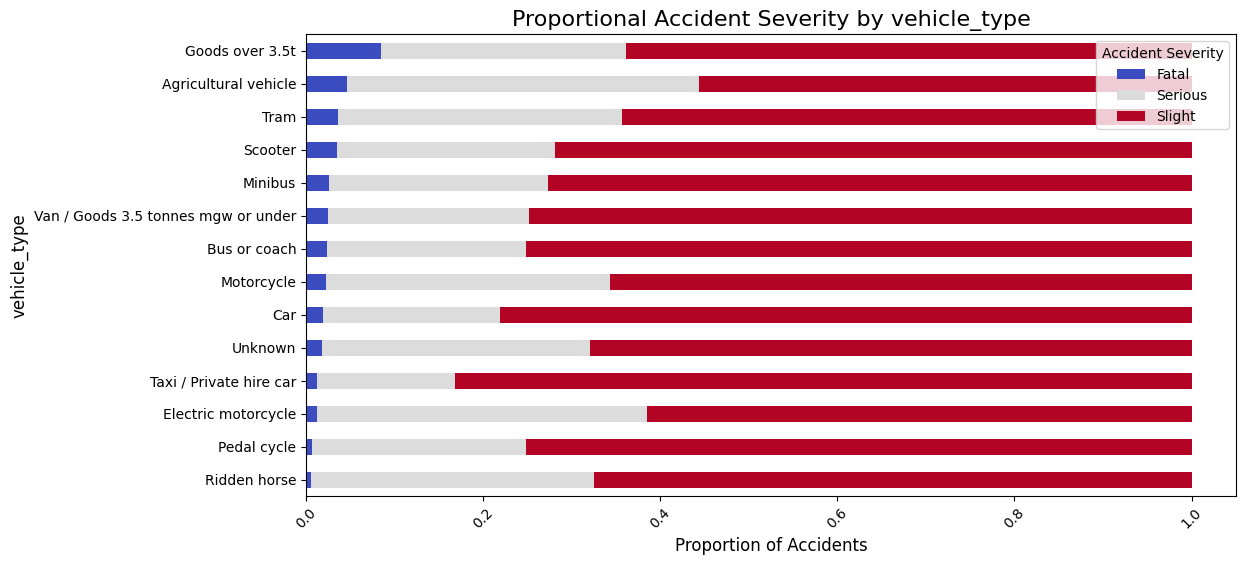

In [48]:
print_stacked_plot("vehicle_type", vehicle_type_mapping)

It makes sense, truck are really heavy and when in collision with another vehicle, are likely to cause way more damage. Surprising is the low values for the motorcycle, which is considered a dangerous vehicle.

Now, at last for this model, we are going to take a look at the maneuvre they made in the accident.

In [49]:
vehicle_manoeuvre_mapping = {
    "1"  : "Reversing",
    "2"  : "Parked",
    "3"  : "Waiting to go",
    "4"  : "Slowing or stopping",
    "5"  : "Moving off",
    "6"  : "U-turn",
    "7"  : "Turning left",
    "8"  : "Waiting to turn left",
    "9"  : "Turning right",
    "10" : "Waiting to turn right",
    "11" : "Changing lane to left",
    "12" : "Changing lane to right",
    "13" : "Overtaking moving vehivle - offside",
    "14" : "Overtaking static vehicle - offside",
    "15" : "Overtaking - nearside",
    "16" : "Going ahead left-hand bend",
    "17" : "Going ahead right-hand bend",
    "18" : "Going ahead other",
    "-1" : "Unknown",
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


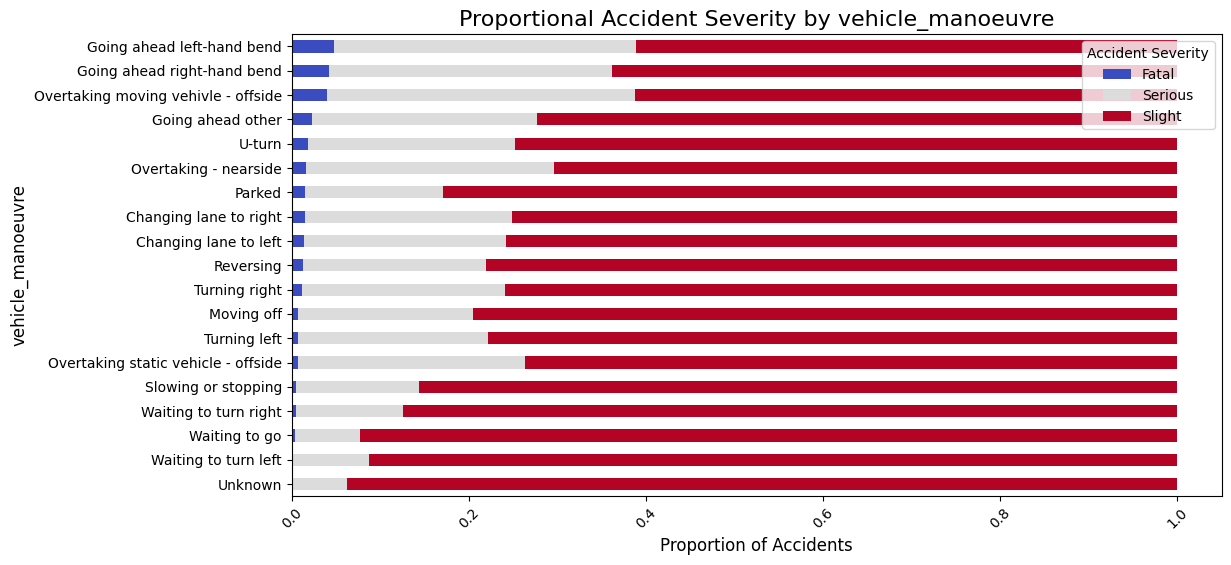

In [50]:
print_stacked_plot("vehicle_manoeuvre", vehicle_manoeuvre_mapping)

This aligns with the fact, that the worst accidents occur in roads outside populated places, but not on the motorway. The most dangerous maneuvers are typical for such roads, especially the overtaking, which is considered the riskiest maneuvre.

#### **5. CatBoost**
The last model we are going to take a deep look into is CatBoost. Again, the training and hyperparameter optimization are in a separate notebook in the "notebooks" folder. Let's load the model now.

In [51]:
catboost_model = CatBoostClassifier()
catboost_model.load_model("models/best_catboost_model_randomized_search.cbm")

In [52]:
catboost_model.score(X_train, y_train)

0.9815595716198126

In [53]:
catboost_model.score(X_test, y_test)

0.7918875502008033

In [54]:
y_pred = catboost_model.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.43      0.56      2367
           2       0.54      0.56      0.55     25007
           3       0.87      0.87      0.87     84676

    accuracy                           0.79    112050
   macro avg       0.74      0.62      0.66    112050
weighted avg       0.79      0.79      0.79    112050



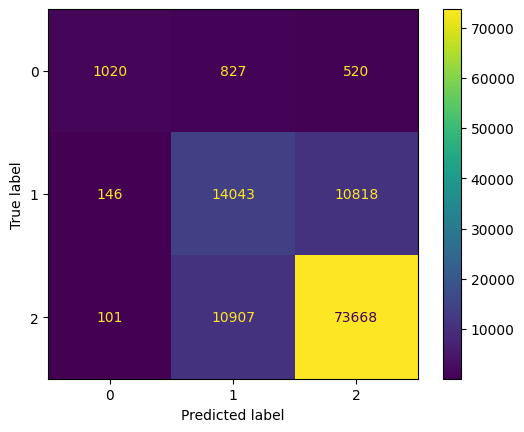

In [56]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

It performed better than XGBoost and about the same as RandomForest. Let's see what it has to say about its features:

In [57]:
catboost_model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,day_of_month,6.819671
1,engine_capacity_cc,6.202791
2,time_rounded,5.778921
3,month,5.450159
4,age_of_driver,5.282946
5,age_of_vehicle,5.139190
6,day_of_week,4.475835
7,accident_year,4.052992
8,vehicle_direction_from,3.974631
9,vehicle_manoeuvre,3.965975


It's strange, that the most important feature is the day of the month. Let's visualize this:

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


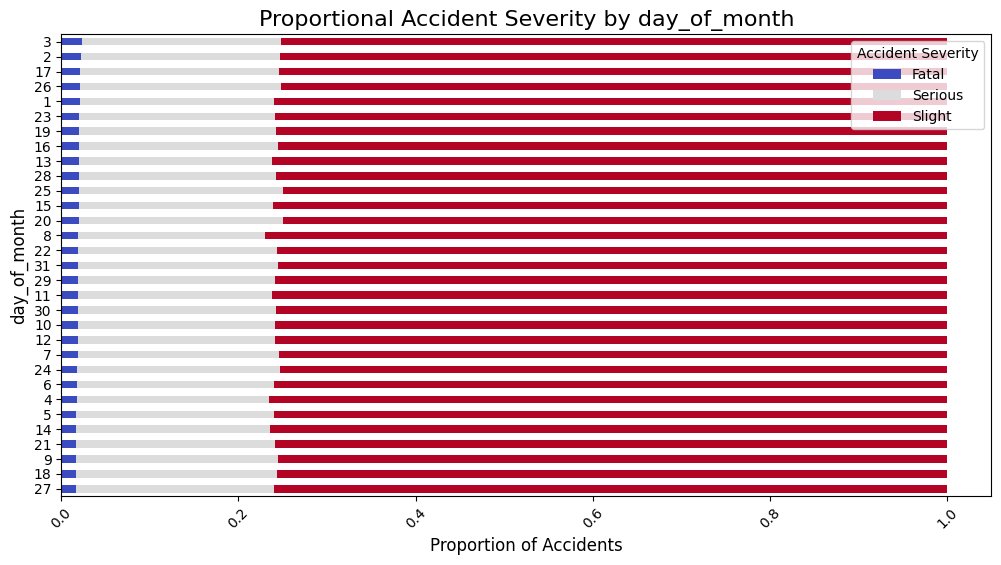

In [58]:
print_stacked_plot("day_of_month", {n : n for n in data["day_of_month"].unique()})

The plot isn't pretty at all, but it's clear, that there is no apparent emerging pattern. That's strange. Another important metric, according to CatBoost, is the month. Let's inspect it:

In [59]:
month_mapping = {
    "1" : "January",
    "2" : "February",
    "3" : "March",
    "4" : "April",
    "5" : "May",
    "6" : "June",
    "7" : "July",
    "8" : "August",
    "9" : "September",
    "10": "October",
    "11": "November",
    "12": "December"
}

/tmp/ipykernel_4888/1434879978.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_proportions = grouped.apply(


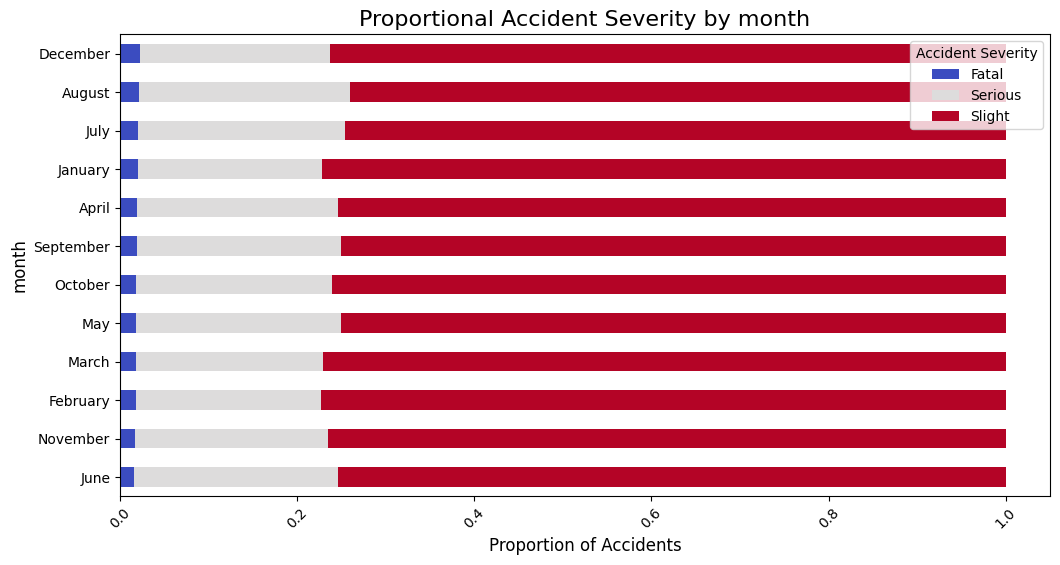

In [60]:
print_stacked_plot("month", month_mapping)

There is also no clear emerging pattern here, which is strange again.

CatBoost failed to give us any new pattern we can explore.

With that, our model evaluation end data exploration concludes. It's time to get into the final step of the project:

## **4. Conclusion**

In the end, based on our findings, we can make the following conclusions:
1. Most of the accidents are not fatal and don't lead to injuries.
2. Bad weather conditions actually decrease the chances of an accident to be fatal
3. Most accidents happen in populated places
4. The worse the lighting, the worse the accident
5. People with stronger cars tend to drive them more dangerously
6. Young people tend to drive more dangerously
7. The most dangerous roads are the ones outside of populated places, excluding the motorways
8. Older people tend to be more likely to have a fatal outcode, when involved in an accident
9. Collisions, involving trucks are more dangerous
10. Turning on a fast road and overtaking are the most dangerous maneuvers

These findings highlight the multifaceted nature of road accidents and their contributing factors. They emphasize the importance of tailoring road safety measures to specific demographics, vehicle types, and environmental conditions. Understanding these trends can help policymakers, urban planners, and safety advocates design interventions that address the root causes of severe accidents.

By prioritizing driver education, enforcing stricter safety regulations, and improving road infrastructure, we can mitigate the risks associated with dangerous behaviors and conditions. Furthermore, raising awareness about these findings could lead to more informed decision-making by drivers, potentially saving lives and reducing injury rates.

In conclusion, while accidents are complex events influenced by a myriad of factors, leveraging data and machine learning has provided actionable insights that can guide efforts to make roads safer for everyone.

## **5. References**
1. Department for Transport. (n.d.). Road Safety Data: Accidents, Vehicles and Casualties. [Dataset]. UK Government. Retrieved from https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data
2.  Department for Transport. (2023). Reported road casualties in Great Britain: Annual report 2023. Retrieved from https://www.gov.uk/government/statistics/reported-road-casualties-great-britain-annual-report-2023
3.  Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A. V., & Gulin, A. (2018). CatBoost: unbiased boosting with categorical features. Advances in Neural Information Processing Systems, 31. Retrieved from https://arxiv.org/abs/1706.09516
4.  Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785-794. Retrieved from https://doi.org/10.1145/2939672.2939785